# Convolutional Autoencoders


An autoencoder is a type of neural network architecture that aims to copy its input to its output by learning an efficient, compressed representation of the data. It functions through two main components: an encoder that compresses the input into a low dimensional layer, also known as a latent space, and a decoder that attempts to reconstruct the original input from that compressed layer. By forcing the data through this bottleneck, the network cannot just memorize the input, instead, it learns the most essential features, patterns, and structures to achieve a good reconstruction.

## Functions

In [2]:
# Import libraries
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.express as px
from tensorflow.keras.models import Model
import pandas as pd
from tqdm import tqdm
import pickle

### Build Autoencoder

In [3]:
def build_autoencoder(input_shape=(32, 32, 3), 
                      latent_filters=16, 
                      kernel_size=(3, 3),
                      remove_layer=True,
                      padding='same',
                      strides=1):
    
    # Input layer
    input_layer = tf.keras.layers.Input(shape=input_shape)
    
    # Encoder
    x = tf.keras.layers.Conv2D(8, kernel_size, activation='relu', padding=padding, strides=strides)(input_layer)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding=padding)(x)
    if remove_layer:
        x = tf.keras.layers.Conv2D(12, kernel_size, activation='relu', padding=padding, strides=strides)(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding=padding)(x)
    
    # Latent Space
    encoded = tf.keras.layers.Conv2D(latent_filters, kernel_size, activation='relu', padding=padding)(x)

    # Decoder
    if remove_layer:
        x = tf.keras.layers.UpSampling2D((2, 2))(encoded)
        if strides > 1:
            x = tf.keras.layers.UpSampling2D((strides, strides))(x)
        x = tf.keras.layers.Conv2D(12, kernel_size, activation='relu', padding=padding)(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x if remove_layer else encoded)
    if strides > 1:
        x = tf.keras.layers.UpSampling2D((strides, strides))(x)
    decoded = tf.keras.layers.Conv2D(3, kernel_size, activation='sigmoid', padding=padding)(x)
    
    # Create the autoencoder model
    autoencoder = tf.keras.models.Model(input_layer, decoded)

    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    
    return autoencoder

### Train Autoencoder

In [4]:
def train_autoencoder(autoencoder, x_train, x_val, epochs = 50, y_train = None, y_val = None):
    
    if y_train is None:
        y_train = x_train

    if y_val is None:
        y_val = x_val
    
    # Train the autoencoder
    train_history = autoencoder.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_val, y_val))
    
    return train_history

### Evaluate Autoencoder

In [5]:
def evaluate_autoencoder(autoencoder, x_test):
    # Evaluate the autoencoder
    test_loss = autoencoder.evaluate(x_test, x_test)
    print(f'Test Loss: {test_loss}')

    return test_loss

### Plot images

In [6]:
def plot_images(models_list, model_names, images, n=10):
    
    # Get predictions from all models first
    all_predictions = []
    for model in models_list:
        predictions = model.predict(images[:n])
        all_predictions.append(predictions)

    # Set up the matplotlib plot
    num_models = len(models_list)
    num_rows = 1 + num_models  
    
    # Create a grid with 'n' cols and 'num_rows' rows
    fig, axes = plt.subplots(num_rows, n, figsize=(n * 1.0, num_rows * 0.75))

    # Loop and display the images
    for i in range(n):
        
        # Original Image ---
        ax_orig = axes[0, i]
        ax_orig.imshow(images[i])
        ax_orig.axis('off')
        if i == 0:
            ax_orig.set_title("Original", fontsize=10)

        # Subsequent Rows: Model Reconstructions
        for j in range(num_models):
            ax_recon = axes[j + 1, i]
            
            # Get the correct prediction: from the j-th model, the i-th image
            recon_img = all_predictions[j][i]
            recon_img = np.clip(recon_img, 0, 1)
            
            ax_recon.imshow(recon_img)
            ax_recon.axis('off')
            if i == 0:
                ax_recon.set_title(model_names[j], fontsize=10)

    plt.tight_layout(pad=0)
    plt.show()

In [7]:
import plotly.graph_objects as go

def plot_comparison_full(df, experiment="All Experiments"):

    fig = go.Figure()
    experiments = df['Experiment'].unique()
    colors = px.colors.qualitative.Plotly[:len(experiments)]
    color_map = dict(zip(experiments, colors))
    
    for index, row in df.iterrows():
        history = row['History']
        name = row['Experiment']
        epochs = list(range(1, len(history['loss']) + 1))
        exp_color = color_map.get(name, 'black')
        
        # 1. Add Training Loss (Dashed)
        fig.add_trace(go.Scatter(
            x=epochs, 
            y=history['loss'],
            mode='lines',
            name=f'{name} (Train)',
            line=dict(dash='dash', color=exp_color),
            legendgroup=name
        ))

        # 2. Add Validation Loss (Solid)
        fig.add_trace(go.Scatter(
            x=epochs, 
            y=history['val_loss'],
            mode='lines',
            name=f'{name} (Val)',
            line=dict(dash='solid', color=exp_color),
            legendgroup=name
        ))

    fig.update_layout(
        title=f'Comparison: Training vs Validation Loss - {experiment}',
        xaxis_title='Epoch',
        yaxis_title='Loss (MSE)',
        legend_title='Experiment',
        template='plotly_white',
        height=600
    )
    fig.show()

In [8]:
def plot_training_history(train_history):
    # Plot training & validation loss values
    fig = px.line(x=train_history.epoch, 
                  y=[train_history.history['loss'], train_history.history['val_loss']],
                  labels={'x': 'Epoch', 'y': 'Loss'},
                  title='Model Loss')
    fig.update_layout(legend_title_text='Legend')
    fig.data[0].name = 'Train Loss'
    fig.data[1].name = 'Validation Loss'
    fig.show()

### Calculate SSIM

In [9]:
def calculate_ssim(autoencoder, x_test):
    
    reconstructed = autoencoder.predict(x_test)
    
    # Clip values to be strictly between 0 and 1
    # just in case of minor numerical instabilities.
    x_test = np.clip(x_test, 0., 1.)
    reconstructed = np.clip(reconstructed, 0., 1.)
    
    # SSIM (Structural Similarity Index)
    # Measures perceptual difference (luminance, contrast, structure).
    ssim_values = tf.image.ssim(x_test, reconstructed, max_val=1.0)
    ssim_score = tf.reduce_mean(ssim_values).numpy()
    
    return ssim_score

## Exercise 1

For the first exercise, we will build an autoencoder based on the architecture shown below. The implementation consists of the following layers:

- Convolutional layer, with 8 filters of size 3x3
- Max Pooling layer, with a pool size of 2x2
- Convolutional layer, with 12 filters of size 3x3
- Max Pooling layer, with a pool size of 2x2
- Convolutional layer, with 16 filters of size 3x3 (Latent space)
- Upsampling layer, with a pool size of 2x2
- Convolutional layer, with 12 filters of size 3x3
- Upsampling layer, with a pool size of 2x2
- Convolutional layer, with 3 filters of size 3x3

<center>
<img src="images/image1.png" alt="Autoencoder" width="500">
</center>

### Getting data

The dataset was obtained using the Keras library. Although Keras provides a defined split function, the data was concatenated and splitted to allow for custom training and testing percentages. Following this, the data was normalized by scaling the pixel values from the original range of [0, 255] to [0, 1].

In [10]:
def get_data():
    # Load data
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    x_full = np.concatenate((x_train, x_test), axis=0)
    y_full = np.concatenate((y_train, y_test), axis=0)

    # Split data
    x_train, x_temp, y_train, y_temp = train_test_split(x_full, y_full, test_size=0.2, random_state=42)
    x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
    print(f"Training set shape: {x_train.shape}, {y_train.shape}")
    print(f"Validation set shape: {x_val.shape}, {y_val.shape}")
    print(f"Test set shape: {x_test.shape}, {y_test.shape}")

    # Normalization - Scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_val = x_val.astype("float32") / 255
    x_test = x_test.astype("float32") / 255

    # Convert class vectors to binary class matrices
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_val = tf.keras.utils.to_categorical(y_val, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    #Return data
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [11]:
# Load and preprocess data
(x_train, y_train), (x_val, y_val), (x_test, y_test) = get_data()

Training set shape: (48000, 32, 32, 3), (48000, 1)
Validation set shape: (6000, 32, 32, 3), (6000, 1)
Test set shape: (6000, 32, 32, 3), (6000, 1)


### Building Autoencoder

The autoencoder follows the architecture defined above, the following configuration is used:

- **Input**: An input layer of 32x32x3 dimensions is used to represent the input image.

- **Convolutional Layers**: Five convolutional layers, all of them uses filters of size 3x3, a stride of 1, and 'same' padding to preserve the spatial dimensions of the feature maps. These layers use RELU as activation function.

- **Pooling Layers**: Two max pooling layers, each with a pool size of 2x2 and a stride of 2, are used to downsample the layers. These layers are used in the encoder part.

- **Upsampling Layers**: Two upsampling layers, each with a pool size of 2x2 and a stride of 2, are used to upsample the layers.

- **Output Activation**: A sigmoid function is used in the output layer to ensure the reconstructed pixel values fall within the [0, 1] interval.

- **Optimizer**: The Adam algorithm is utilized for training to leverage its momentum and adaptive learning rate capabilities. 

In [12]:
# Experiment 0 - Baseline
results_list = []
exp_name = "Baseline"
params = {'input_shape': '(32, 32, 3)', 
          'latent_filter':16, 
          'kernel_size':'(3, 3)',
          'remove_layer':True,
          'padding':'same',
          'strides':1}
# Build the autoencoder
autoencoder = build_autoencoder()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 12)     │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 16)       │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 12)     │         1,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 3)      │           327 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,911 (19.18 KB)

 Trainable params: 4,911 (19.18 KB)

 Non-trainable params: 0 (0.00 B)

In the summary table of the autoencoder we can notice that it has 4911 trainable parameters. It means that it has 4911 weights and biases that are being optimized during training.

### Training

In [13]:
# Hardcode parameters
epochs = 20 

In [14]:
# Train the autoencoder
train_history = train_autoencoder(autoencoder, x_train, x_val, epochs=epochs)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0209 - val_loss: 0.0118
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0103 - val_loss: 0.0092
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━

### Evaluation

First let's evaluate what is the loss value from out test dataset

In [15]:
# Evaluate the autoencoder
test_loss = evaluate_autoencoder(autoencoder, x_test)

# Store results
results_list.append({
    'Experiment': exp_name,
    'Test MSE': test_loss,
    'Val Loss': train_history.history['val_loss'][-1],
    'History': train_history.history,
    'Parameters': str(params)
})

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0055
Test Loss: 0.005498905200511217


We are getting a loss value very close to 0. That means the autoencoder is able to reconstruct the input data very well.

Now let's check a plot of the loss over epochs.


In [16]:
# Plot training history
plot_training_history(train_history)

The training plot demonstrates excellent generalization, as evidenced by the near overlap between the training loss and validation loss curves, this confirms the autoencoder is not overfitting the dataset. The smooth, consistent decline in both curves throughout the training process is suggesting the Adam optimizer is doing a good job localizing the global minimum. By the final epochs, the clear flattening of both lines signifies that the model has converged, indicating that the autoencoder has successfully learned the most important patterns in the data.

Now let's pass some images of our dataset and see how the autoencoder performs.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


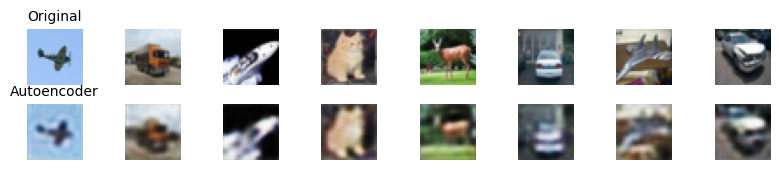

In [17]:
# Plotting images
plot_images([autoencoder], ['Autoencoder'], images = x_test, n = 8)

We can see that each image is reconstructed with an acceptable quality. The autoencoder was able to recognize the patterns and general features of the images.

Now we will calculate the Structural Similarity Index Measure (SSIM). This metric measures the similarity between two images by modeling how the human perceive the images. It works by comparing the luminance, contrast and structure of the images. The resulting score, which ranges from -1 to 1, indicates the quality of the reconstruction.

In [18]:
ssim_score = calculate_ssim(autoencoder, x_test)
print("SSIM score:", ssim_score)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
SSIM score: 0.7461397


We got a SSIM of 0.78 which is a good result that indicates that reconstruction is almost similar to the original image.

## Exercise 2

### 2.1 Latent space size
To compute the size of the latent representation, we use the standard formula for the spatial output size of a convolutional layer:
$$
Size = \left( \frac{W - K + 2P}{S} + 1 \right)^2 * C
$$

Where:
- $W$: Input volume
- $K$: Kernel size (filter size)
- $P$: Padding
- $S$: Stride
- $C$: Number of channels

*Latent layer input:*
- In our implementation, the encoder reduces the image spatial dimensions from: $32×32→16×16→8×8$
- After the two max-pooling operations, the tensor entering the latent convolution has shape: $8×8×12$
- Then, we apply a Conv2D layer with 16 filters ($C =16$) to produce the latent representation.

So:
- $W = 8 x 8 = 8$
- $K = 3 x 3 = 3$
- $P = 1 $
- $S = 1$
- $C = 16$

So:
- $Size = \left( \frac{8 - 3 + 2(1)}{1} + 1 \right)^2 * 16 = 64 * 16 = 1024$

This means the bottleneck encodes each image as a tensor of shape: $8×8×16$ for a total of 1024 latent features.

The bottleneck forces the model to compress the input into a compact representation, capturing only essential features like shapes and colors. This restriction prevents simple memorization, ensuring the network learns the underlying patterns necessary to reconstruct the image efficiently.




### 2.2 Other architectures
#### 2.2.1. Experiment 1 - Latent space variations
The comparison shows that latent space size has a clear impact on reconstruction performance. The small-latent model consistently exhibits the highest loss, indicating insufficient representational capacity. The baseline performs moderately well, while the large latent space (32) achieves the lowest training and validation errors throughout training.

Despite the stability of the training curves suggesting no immediate overfitting, the reduced compression ratio in the larger models implies a shift toward trivial identity mapping rather than the meaningful abstraction seen in tighter bottlenecks

In [19]:
def run_experiments(variations, epochs, results_list):
    for var in tqdm(variations):
        
        # 1. Build
        model = build_autoencoder(input_shape=(32, 32, 3), **var['params'])
        
        # 2. Train
        hist = train_autoencoder(model, x_train, x_val, epochs=epochs)
        
        # 3. Evaluate
        test_loss = evaluate_autoencoder(model, x_test)
        
        # 4. Store
        results_list.append({
            'Experiment': var['name'],
            'Test MSE': test_loss,
            'Val Loss': hist.history['val_loss'][-1],
            'History': hist.history,
            'Parameters': str(var['params'])
        })

In [20]:
# Store setups
variations = [
    {'name': 'Small Latent (4)', 'params': {'latent_filters': 4}},
    {'name': 'Large Latent (32)', 'params': {'latent_filters': 32}}
]

run_experiments(variations, epochs, results_list)

  0%|          | 0/2 [00:00<?, ?it/s]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 12)     │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 4)        │           436 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 12)     │           444 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 3)      │           327 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,307 (9.01 KB)

 Trainable params: 2,307 (9.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.0299 - val_loss: 0.0158
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0144 - val_loss: 0.0137
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0127 - val_loss: 0.0112
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━

 50%|█████     | 1/2 [02:39<02:39, 159.95s/it]

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 12)     │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 32)       │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 12)     │         3,468 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 3)      │           327 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,383 (32.75 KB)

 Trainable params: 8,383 (32.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 0.0223 - val_loss: 0.0115
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.0100 - val_loss: 0.0088
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━

100%|██████████| 2/2 [05:54<00:00, 177.37s/it]

In [21]:
# Show Table
df_current = pd.DataFrame(results_list)
exp_list = ['Baseline', 'Small Latent (4)', 'Large Latent (32)']
df_current = df_current[df_current['Experiment'].isin(exp_list)]
display(df_current)

,Experiment,Test MSE,Val Loss,History,Parameters
0,Baseline,0.005499,0.005463,"{'loss': [0.020921556279063225, 0.010271179489...","{'input_shape': '(32, 32, 3)', 'latent_filter'..."
1,Small Latent (4),0.007710,0.007726,"{'loss': [0.029887903481721878, 0.014444834552...",{'latent_filters': 4}
2,Large Latent (32),0.005106,0.005073,"{'loss': [0.022294195368885994, 0.009992155246...",{'latent_filters': 32}


In [22]:
# Plot comparison
plot_comparison_full(df_current, experiment="Latent Space Variations")

##### Latent space plot

In [ ]:
import pandas as pd
def plot_latent_space_3d(trained_autoencoder, bottleneck_layer_name, images, one_hot_labels, n_samples=5000):
    
    # --- 1. Create the encoder model (Igual que antes) ---
    try:
        model_input = trained_autoencoder.input
        model_output = trained_autoencoder.get_layer(bottleneck_layer_name).output
        encoder_model = Model(inputs=model_input, outputs=model_output)
    except Exception as e:
        print(f"ERROR: Could not create encoder. Layer name correct?")
        print(f"Run 'autoencoder.summary()' to find the name.")
        print(f"Details: {e}")
        return

    if n_samples > len(images): n_samples = len(images)

    print("Generating latent space vectors...")
    x_sample = images[:n_samples]
    y_sample_one_hot = one_hot_labels[:n_samples]
    
    # Convert from one-hot to integers (0, 1, 2...)
    y_sample_int = np.argmax(y_sample_one_hot, axis=1)

    # Pass data through encoder
    latent_vectors = encoder_model.predict(x_sample)
    latent_vectors_flat = latent_vectors.reshape((n_samples, -1))

    # --- 2. Run t-SNE (Igual que antes) ---
    print("Running 3D t-SNE (this may take a while)...")
    tsne = TSNE(n_components=3, perplexity=30, max_iter=1000, verbose=1)
    tsne_results = tsne.fit_transform(latent_vectors_flat)
    print("3D t-SNE complete.")

    # --- 3. Prepare Data for Plotly ---
    print("Creating interactive plot...")
    
    # Convertimos los números (0, 1) a nombres reales ('airplane', 'car')
    # Esto hará que el gráfico sea mucho más fácil de leer al pasar el mouse
    label_names = [cifar10_labels[i] for i in y_sample_int]

    # Creamos un DataFrame de Pandas. Plotly adora los DataFrames.
    df = pd.DataFrame({
        'x': tsne_results[:, 0],
        'y': tsne_results[:, 1],
        'z': tsne_results[:, 2],
        'label': label_names  # Usamos los nombres para la leyenda
    })

    # --- 4. Generate Plotly Chart ---
    fig = px.scatter_3d(
        df, 
        x='x', y='y', z='z',
        color='label',  # Colorea automáticamente según la clase
        title='Latent Space 3D Visualization (CIFAR-10)',
        labels={'label': 'Class'}, # Título de la leyenda
        opacity=0.7,     # Un poco de transparencia ayuda a ver cúmulos densos
        height=800,       # Altura del gráfico en píxeles
        width=1000
    )

    # Ajustes visuales finos
    fig.update_traces(marker=dict(size=3)) # Puntos más pequeños para ver mejor los detalles
    fig.update_layout(
        scene=dict(
            xaxis_title='t-SNE 1',
            yaxis_title='t-SNE 2',
            zaxis_title='t-SNE 3'
        ),
        legend_title_text='Classes'
    )

    fig.show()

In [ ]:
# Call the plotting function with the correct variables
plot_latent_space_3d(autoencoder_small_ls, 'conv2d_2', x_test, y_test)

In [ ]:
evaluate_reconstruction_quality(autoencoder_small_ls, x_test)

In [ ]:
evaluate_reconstruction_quality(autoencoder, x_test)

#### 2.2.2. Experiment 2 - Modify kernel size
The analysis confirms that kernel size plays a decisive role in reconstruction quality, largely because it dictates how much spatial and color information the model processes at once. Since the model must interpret RGB images, having a sufficient 'field of view' is critical. The results show that small kernels (2×2) are ineffective; they are simply too narrow to capture meaningful patterns or textures, leading to consistently high error rates. In contrast, the baseline 3×3 kernels strike the optimal balance. They are large enough to recognize key features like edges and color transitions but remain computationally efficient. While larger kernels (5×5) can capture a broader context and achieve slightly lower loss, this comes at the cost of added complexity and a tendency to blur fine details ('over-smoothing'). Therefore, the 3×3 configuration proves to be the most robust choice, avoiding the limitations of the smaller kernels while maintaining better clarity than the larger ones.

In [40]:
# Store setups
variations = [
    {'name': 'Kernel (2,2)', 'params': {'kernel_size': (2,2)}},
    {'name': 'Kernel (5,5)', 'params': {'kernel_size': (5,5)}}
]

run_experiments(variations, epochs, results_list)

  0%|          | 0/2 [00:00<?, ?it/s]

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 8)      │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 12)     │           396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 16)       │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 12)     │           780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 3)      │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,211 (8.64 KB)

 Trainable params: 2,211 (8.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0311 - val_loss: 0.0152
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0128 - val_loss: 0.0114
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0106 - val_loss: 0.0101
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━

 50%|█████     | 1/2 [02:46<02:46, 166.67s/it]

Test Loss: 0.006998428143560886


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 8)      │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 12)     │         2,412 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 8, 16)       │         4,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 12)     │         4,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 3)      │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,551 (52.93 KB)

 Trainable params: 13,551 (52.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - loss: 0.0221 - val_loss: 0.0128
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - loss: 0.0113 - val_loss: 0.0100
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 0.0087 - val_loss: 0.0098
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 12/20
188/188 ━━━━━━━━━━

100%|██████████| 2/2 [07:02<00:00, 211.46s/it]

Test Loss: 0.0058393944054841995


In [41]:
# Show Table
df_current = pd.DataFrame(results_list)
exp_list = ['Baseline', 'Kernel (2,2)', 'Kernel (5,5)']
df_current = df_current[df_current['Experiment'].isin(exp_list)]
display(df_current)

,Experiment,Test MSE,Val Loss,History,Parameters
2,Baseline,0.005382,0.005353,"{'loss': [0.02377995103597641, 0.0109980963170...","{'input_shape': '(32, 32, 3)', 'latent_filter'..."
3,"Kernel (2,2)",0.006998,0.006971,"{'loss': [0.031096437945961952, 0.012768846936...","{'kernel_size': (2, 2)}"
4,"Kernel (5,5)",0.005839,0.005816,"{'loss': [0.022112596780061722, 0.011303756386...","{'kernel_size': (5, 5)}"


In [42]:
# Plot comparison
plot_comparison_full(df_current, experiment="Kernel Size Variations")

#### 2.2.3. Experiment 3 - Shallow and High Stride
Reducing the number of layers (shallow model) and increasing downsampling via strided convolutions (stride = 2) both negatively impact reconstruction performance. The shallow model converges close to the baseline but consistently maintains a slightly higher loss due to limited feature-extraction capacity. In contrast, the strided model shows the worst performance, as aggressive early downsampling causes significant information loss and leads to higher training and validation errors throughout. The baseline architecture remains the most effective, preserving spatial and color detail while maintaining stable convergence.

In [43]:
# Store setups
variations = [
    {'name': 'Shallow (Fewer Layers)', 'params': {'remove_layer': True}}, 
    {'name': 'High Stride (2)', 'params': {'strides': 2}} 
]

run_experiments(variations, epochs, results_list)

  0%|          | 0/2 [00:00<?, ?it/s]

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 12)     │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 8, 8, 16)       │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 16, 16, 12)     │         1,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 32, 32, 3)      │           327 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,911 (19.18 KB)

 Trainable params: 4,911 (19.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0237 - val_loss: 0.0118
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0099 - val_loss: 0.0089
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0068 - val_loss: 0.0066
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━

 50%|█████     | 1/2 [02:37<02:37, 157.58s/it]

Test Loss: 0.00518610468134284


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 16, 16, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 4, 4, 12)       │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 2, 2, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 2, 2, 16)       │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 8, 8, 12)       │         1,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_14 (UpSampling2D) │ (None, 16, 16, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_15 (UpSampling2D) │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 32, 32, 3)      │           327 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,911 (19.18 KB)

 Trainable params: 4,911 (19.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.0406 - val_loss: 0.0304
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0284 - val_loss: 0.0274
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0265 - val_loss: 0.0261
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0255 - val_loss: 0.0253
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0247 - val_loss: 0.0245
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0242 - val_loss: 0.0240
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0237 - val_loss: 0.0236
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0233 - val_loss: 0.0233
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0230 - val_loss: 0.0230
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0228 - val_loss: 0.0229
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0225 - val_loss: 0.0227
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 

100%|██████████| 2/2 [04:36<00:00, 138.28s/it]

Test Loss: 0.021530380472540855


In [44]:
# Show Table
df_current = pd.DataFrame(results_list)
exp_list = ['Baseline', 'Shallow (Fewer Layers)', 'High Stride (2)']
df_current = df_current[df_current['Experiment'].isin(exp_list)]
display(df_current)

,Experiment,Test MSE,Val Loss,History,Parameters
2,Baseline,0.005382,0.005353,"{'loss': [0.02377995103597641, 0.0109980963170...","{'input_shape': '(32, 32, 3)', 'latent_filter'..."
5,Shallow (Fewer Layers),0.005186,0.005157,"{'loss': [0.02370760403573513, 0.0099259894341...",{'remove_layer': True}
6,High Stride (2),0.021530,0.021520,"{'loss': [0.04055134207010269, 0.0284310560673...",{'strides': 2}


In [45]:
# Plot comparison
plot_comparison_full(df_current, experiment="Shallow vs Strided Variations")

In [47]:
with open('experiments.pkl', 'wb') as f:
    pickle.dump(results_list, f)

## Exercise 3

In [ ]:
def rgb_to_gray(images):
    """Convert RGB [N,32,32,3] → Grayscale [N,32,32,1]."""
    return np.dot(images[...,:3], [0.299, 0.587, 0.114])[..., np.newaxis]

x_train_gray = tf.image.rgb_to_grayscale(x_train)
x_val_gray   = tf.image.rgb_to_grayscale(x_val) 
x_test_gray  = tf.image.rgb_to_grayscale(x_test)

In [ ]:
# Build the autoencoder
autoencoder_gray_color = build_autoencoder(input_shape=(32, 32, 1))

In [ ]:
# Train the autoencoder
train_history = train_autoencoder(autoencoder_gray_color, x_train_gray, x_val_gray, epochs=epochs, y_train = x_train, y_val = x_val)

In [ ]:
# Evaluate the autoencoder
test_loss = evaluate_autoencoder(autoencoder_gray_color, x_test_gray)

In [ ]:
# Plot training history
plot_training_history(train_history)

In [ ]:
# Plotting images
plot_images([autoencoder_gray_color], ['Autoencoder'], images = x_test_gray, n = 8)